In [10]:
"""
1、特征EDA
2、特征衍生
3、单模参数调优（分别对多个模型进行参数调优）
4、多模型融合参数调优
"""

'\n1、特征EDA\n2、特征衍生\n3、单模参数调优（分别对多个模型进行参数调优）\n4、多模型融合参数调优\n'

In [11]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cat

import optuna
from optuna.samplers import TPESampler

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixinxw

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
import warnings

warnings.filterwarnings('ignore')

In [29]:
%%time

df_train = pd.read_csv('./playground-series-s4e5/train.csv')
df_test = pd.read_csv('./playground-series-s4e5/test.csv')

df_sub = pd.read_csv('./playground-series-s4e5/sample_submission.csv')

df_train.set_index('id', inplace=True)
df_test.set_index('id', inplace=True)

CPU times: user 926 ms, sys: 237 ms, total: 1.16 s
Wall time: 1.19 s


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1117957 entries, 0 to 1117956
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1117957 non-null  int64  
 1   TopographyDrainage               1117957 non-null  int64  
 2   RiverManagement                  1117957 non-null  int64  
 3   Deforestation                    1117957 non-null  int64  
 4   Urbanization                     1117957 non-null  int64  
 5   ClimateChange                    1117957 non-null  int64  
 6   DamsQuality                      1117957 non-null  int64  
 7   Siltation                        1117957 non-null  int64  
 8   AgriculturalPractices            1117957 non-null  int64  
 9   Encroachments                    1117957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1117957 non-null  int64  
 11  DrainageSystems                  1117957 non-null  int6

In [ ]:
fea_col_list = [col for col in df_train.columns.tolist() if col not in ['FloodProbability']]
target_col_list = ['FloodProbability']

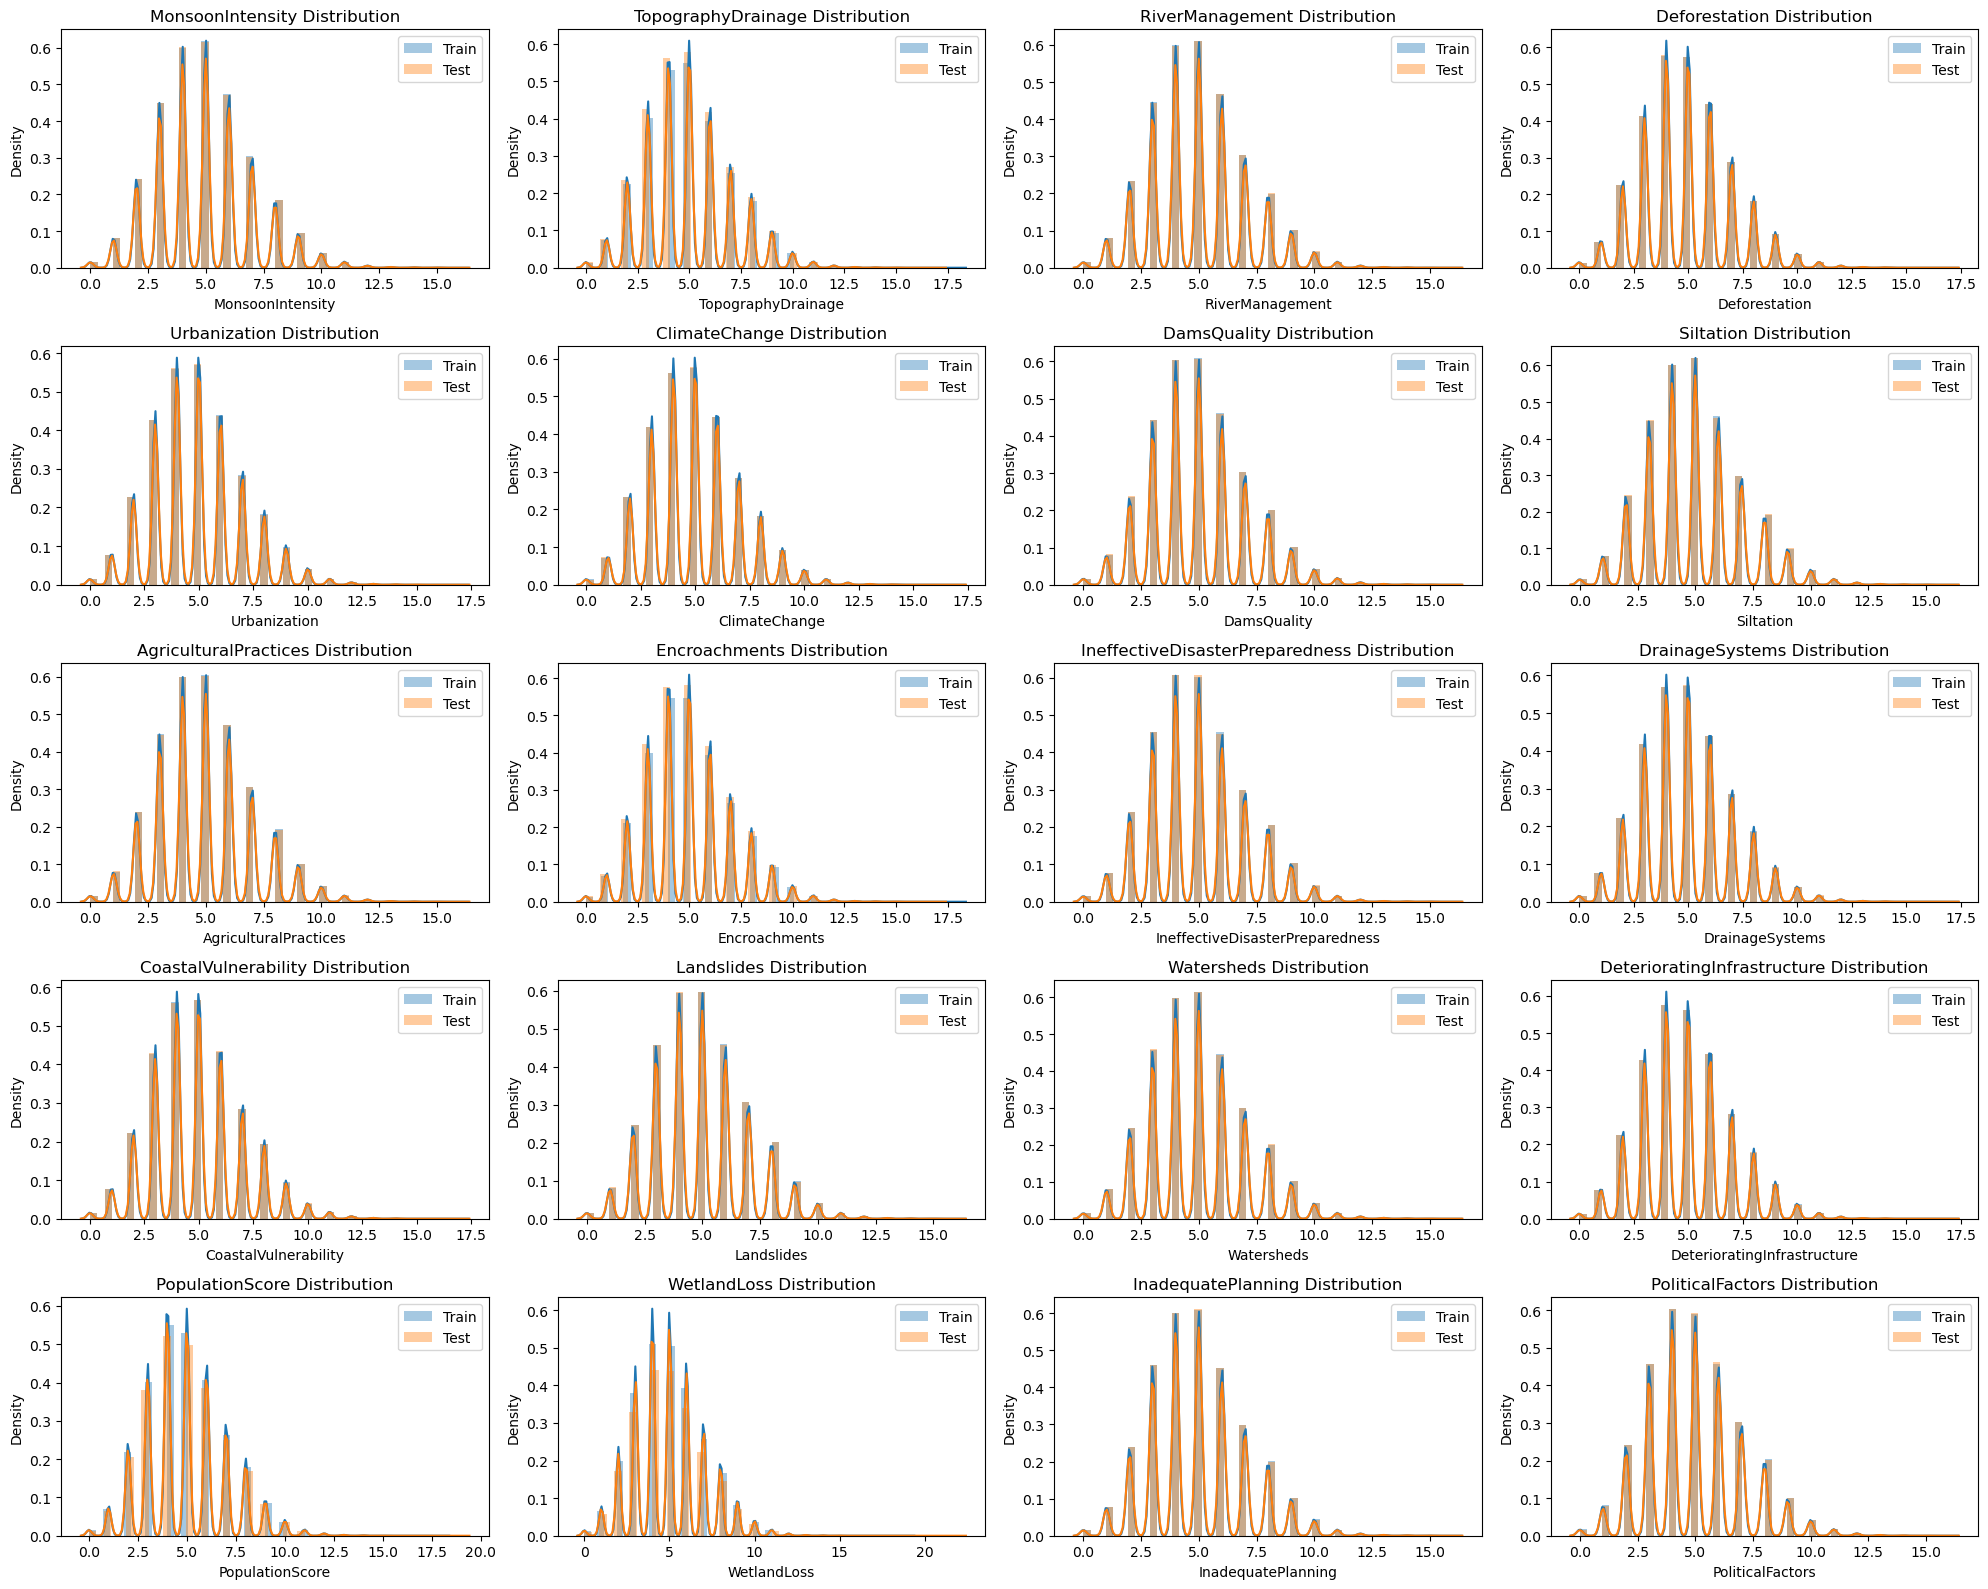

CPU times: user 1min 25s, sys: 34.2 s, total: 1min 59s
Wall time: 1min 18s


In [ ]:
%%time

fig, ax = plt.subplots(5, 4, figsize=(5*4, 4*4))

axes = ax.flatten()

for index, col in enumerate(fea_col_list):
    
    sns.distplot(df_train[col], label='Train', ax=axes[index])
    sns.distplot(df_test[col], label='Test', ax=axes[index])
    axes[index].set_title(f'{col} Distribution')
    axes[index].legend()
    
plt.tight_layout()
plt.show()

In [ ]:
%%time

num_cols=['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors']

unique_vals = []
for df in [df_train, df_test]:
    for col in num_cols:
        unique_vals += list(df[col].unique())

unique_vals = list(set(unique_vals))

class GetFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['ClimateAnthropogenicInteraction'] = (X['MonsoonIntensity'] + X['ClimateChange']) * (X['Deforestation'] + X['Urbanization'] + X['AgriculturalPractices'] + X['Encroachments'])
        X['InfrastructurePreventionInteraction'] = (X['DamsQuality'] + X['DrainageSystems'] + X['DeterioratingInfrastructure']) * (X['RiverManagement'] + X['IneffectiveDisasterPreparedness'] + X['InadequatePlanning'])
        
        X['sum'] = X[num_cols].sum(axis=1)
        X['std']  = X[num_cols].std(axis=1)
        X['mean'] = X[num_cols].mean(axis=1)
        X['max']  = X[num_cols].max(axis=1)
        X['min']  = X[num_cols].min(axis=1)
        X['mode'] = X[num_cols].mode(axis=1)[0]
        X['median'] = X[num_cols].median(axis=1)
        X['q_25th'] = X[num_cols].quantile(0.25, axis=1)
        X['q_75th'] = X[num_cols].quantile(0.75, axis=1)
        X['skew'] = X[num_cols].skew(axis=1)
        X['kurt'] = X[num_cols].kurt(axis=1)
        X['sum_72_76'] = X['sum'].isin(np.arange(72, 76))
        for i in range(10,100,10):
            X[f'{i}th'] = X[num_cols].quantile(i/100, axis=1)
        X['harmonic'] = len(num_cols) / X[num_cols].apply(lambda x: (1/x).mean(), axis=1)
        X['geometric'] = X[num_cols].apply(lambda x: x.prod()**(1/len(x)), axis=1)
        X['zscore'] = X[num_cols].apply(lambda x: (x - x.mean()) / x.std(), axis=1).mean(axis=1)
        X['cv'] = X['std'] / X['mean']
        X['Skewness_75'] = (X[num_cols].quantile(0.75, axis=1) - X[num_cols].mean(axis=1)) / X[num_cols].std(axis=1)
        X['Skewness_25'] = (X[num_cols].quantile(0.25, axis=1) - X[num_cols].mean(axis=1)) / X[num_cols].std(axis=1)
        X['2ndMoment'] = X[num_cols].apply(lambda x: (x**2).mean(), axis=1)
        X['3rdMoment'] = X[num_cols].apply(lambda x: (x**3).mean(), axis=1)
        X['entropy'] = X[num_cols].apply(lambda x: -1*(x*np.log(x)).sum(), axis=1)

        for v in unique_vals:
            if v<16:
                X['cnt_{}'.format(v)] = (X[num_cols] == v).sum(axis=1)
        return X


fea_pipeline = Pipeline([('getfea', GetFeaturesTransformer())])

df_train = fea_pipeline.fit_transform(df_train)
df_test = fea_pipeline.transform(df_test)

CPU times: user 20min 2s, sys: 21.6 s, total: 20min 24s
Wall time: 20min 23s


In [ ]:
fea_col_list = [col for col in df_train.columns.tolist() if col not in ['FloodProbability']]
target_col_list = ['FloodProbability']

# 进行单模参数优化

In [28]:
class OptunaSingel:

    def __init__(self, state, ntrials, metric_obj, data, model_type):
        self.random_state = state
        self.n_trials = ntrials
        self.best_weight = None
        self.direction = metric_obj
        self.data = data
        self.model_type = model_type

    def _objective(self, trial):

        if self.model_type == 'lgb':
            lgb_params = {'objective': 'regression',
                'random_state': 42,
                'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
                'subsample': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
                'learning_rate': trial.suggest_uniform('learning_rate', 0.0, 0.5),
                "max_depth" : trial.suggest_int('max_depth', 3, 8),
                'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
                'num_leaves': trial.suggest_int('max_depth', 3, 200),
                'verbosity': -1}
            model = lgb.LGBMRegressor(**lgb_params)

        elif self.model_type == 'xgb':
            xgb_params = {
                    'n_estimators': trial.suggest_int('n_estimators', 500, 5000),
                    'max_depth': trial.suggest_int('max_depth', 3, 8),
                    'colsample_bytree':trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
                    'learning_rate': trial.suggest_uniform('learning_rate', 0.0, 0.5),
                    'objective': 'reg:squarederror',
                    'seed': 42}
            model = xgb.XGBRegressor(**xgb_params)

        elif self.model_type == 'cat':
            cat_params = {
                'iterations': trial.suggest_int('n_estimators', 500, 5000),
                'depth': trial.suggest_int('max_depth', 3, 8),
                'colsample_bylevel':trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
                'learning_rate': trial.suggest_uniform('learning_rate', 0.0, 0.5),
                'subsample': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
                'min_data_in_leaf': 100,
                'random_state': 42}
            model = cat.CatBoostRegressor(**cat_params)

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        oof = np.zeros(len(self.data))

        for train_index, val_index in kf.split(self.data, self.data[target_col_list]):
            X_train, X_val = self.data[fea_col_list].iloc[train_index], self.data[fea_col_list].iloc[val_index]
            y_train, y_val = self.data[target_col_list].iloc[train_index], self.data[target_col_list].iloc[val_index]
            eval_set = [(X_val, y_val)]
            model.fit(X_train, y_train, eval_set=eval_set)
            y_pred = model.predict(X_val)
            oof[val_index] += y_pred
        
        score = r2_score(self.data[target_col_list], oof)
        return score

    def fit(self):
        self.study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=self.random_state))
        obj = partial(self._objective)
        self.study.optimize(obj, n_trials=self.n_trials)
        self.best_weight = self.study.best_params

    def weight(self):
        return self.best_weight
        

lgb_optuna = OptunaSingel(state=2024, 
                          ntrials=100,
                          metric_obj='maximize',
                          data=df_train,
                          model_type='lgb')
lgb_optuna.fit()
lgb_optuna_best_params = lgb_optuna.weight()


xgb_optuna = OptunaSingel(state=2024, 
                          ntrials=100,
                          metric_obj='maximize',
                          data=df_train,
                          model_type='xgb')
xgb_optuna.fit()
xgb_optuna_best_params = xgb_optuna.weight()


cat_optuna = OptunaSingel(state=2024, 
                          ntrials=100,
                          metric_obj='maximize',
                          data=df_train,
                          model_type='cat')
cat_optuna.fit()
cat_optuna_best_params = cat_optuna.weight()

print('lgb_model最优参数为{}'.format(lgb_optuna_best_params))
print('xgb_model最优参数为{}'.format(xgb_optuna_best_params))
print('cat_model最优参数为{}'.format(cat_optuna_best_params))

In [ ]:
lgb_optuna_best_params

{'colsample_bytree': 0.8102650238775168,
 'learning_rate': 0.037425608942158725,
 'max_depth': 8,
 'n_estimators': 4862}

# 多模型融合比例选择

In [ ]:
%%time 

from gc import collect

class OptunaEnsembler:
    
    def __init__(self, state, ntrials, metric_obj):
        self.study        = None;
        self.weights      = None;
        self.random_state = state;
        self.n_trials     = ntrials;
        self.direction    = metric_obj;
        
    def ScoreMetric(self, ytrue, ypred):
        return r2_score(ytrue, ypred)

    def _objective(self, trial, y_true, y_preds):

        if isinstance(y_preds, pd.DataFrame) or isinstance(y_preds, np.ndarray):
            weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(y_preds.shape[-1])];
            axis = 1;
        elif isinstance(y_preds, list):
            weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))];
            axis = 0;

        # 此部分可参考VoteRegressor里面的源代码
        weighted_pred  = np.average(np.array(y_preds), axis = axis, weights = weights);
        score          = self.ScoreMetric(y_true, weighted_pred);
        return score;

    def fit(self, y_true, y_preds):
        "This method fits the Optuna objective on the fold level data";
        
        self.study = \
        optuna.create_study(sampler    = TPESampler(seed = self.random_state), 
                            # pruner     = HyperbandPruner(),
                            study_name = "Ensemble", 
                            direction  = self.direction,
                           );
        
        obj = partial(self._objective, y_true = y_true, y_preds = y_preds);
        self.study.optimize(obj, n_trials = self.n_trials);
               
        if isinstance(y_preds, list):
            self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))];
        else:
            self.weights = [self.study.best_params[f"weight{n}"] for n in range(y_preds.shape[-1])];

    def predict(self, y_preds):
        "This method predicts using the fitted Optuna objective";
        
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict';
        
        if isinstance(y_preds, list):
            weighted_pred = np.average(np.array(y_preds), axis=0, weights = self.weights);
        else:
            weighted_pred = np.average(np.array(y_preds), axis=1, weights = self.weights);
        return weighted_pred;

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds);
        return self.predict(y_preds);
    
    def weights(self):
        return self.weights
    
print()
collect()


CPU times: user 68.9 ms, sys: 51.2 ms, total: 120 ms
Wall time: 128 ms


0

In [13]:
from tqdm import tqdm

oof_vote = np.zeros((len(df_train), 3))
test_oof_vote = np.zeros((len(df_test), 3))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in tqdm(kf.split(df_train, df_train[target_col_list]), 'KFold——Training'):
    X_train, X_val = df_train[fea_col_list].iloc[train_index], df_train[fea_col_list].iloc[val_index]
    y_train, y_val = df_train[target_col_list].iloc[train_index], df_train[target_col_list].iloc[val_index]

    lgb_params_best = {
    'n_estimators': 4862,
    'max_depth': 8,
    'colsample_bytree':0.8102650238775168,
    'learning_rate': 0.037425608942158725,
    'verbose':-1,
    'metric':'rmse',
    'objective': 'regression',
    'seed': 42}

    xgb_params_best = {
    'n_estimators': 4862,
    'max_depth': 8,
    'colsample_bytree':0.9,
    'learning_rate': 0.01,
    'subsample': 0.9,
    'metric':'mse',
    'objective': 'reg:squarederror',
    'seed': 42}

    cat_params_best = {
    'iterations': 4862,
    'depth': 8,
    'colsample_bylevel':0.9,
    'learning_rate': 0.01,
    'subsample': 0.9,
    'random_state': 42}

    lgbm_model = lgb.LGBMRegressor(**lgb_params_best)
    xgb_model = xgb.XGBRegressor(**xgb_params_best)
    cat_model = cat.CatBoostRegressor(**cat_params_best)

    eval_set = [(X_val, y_val)]

    lgbm_model.fit(X_train, y_train, eval_set=eval_set, callbacks=[lgb.early_stopping(200), lgb.log_evaluation(100)])
    y_pred_lgb = lgbm_model.predict(X_val)
    y_test_pred_lgb = lgbm_model.predict(df_test[fea_col_list])
    oof_vote[val_index, 0] += y_pred_lgb
    test_oof_vote[:, 0] += y_test_pred_lgb/5

    xgb_model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=200, verbose=100)
    y_pred_xgb = xgb_model.predict(X_val)
    y_test_pred_xgb = xgb_model.predict(df_test[fea_col_list])
    oof_vote[val_index, 1] += y_pred_xgb
    test_oof_vote[:, 1] += y_test_pred_xgb/5

    cat_model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=200, verbose=100)
    y_pred_cat = cat_model.predict(X_val)
    y_test_pred_cat = cat_model.predict(df_test[fea_col_list])
    oof_vote[val_index, 2] += y_pred_cat  
    test_oof_vote[:, 2] += y_test_pred_cat/5

KFold——Training: 0it [00:00, ?it/s]

Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.0185384
[200]	valid_0's rmse: 0.0184807
[300]	valid_0's rmse: 0.0184747
[400]	valid_0's rmse: 0.0184712
[500]	valid_0's rmse: 0.0184689
[600]	valid_0's rmse: 0.0184673
[700]	valid_0's rmse: 0.0184666
[800]	valid_0's rmse: 0.0184657
[900]	valid_0's rmse: 0.0184648
[1000]	valid_0's rmse: 0.0184635
[1100]	valid_0's rmse: 0.0184628
[1200]	valid_0's rmse: 0.0184623
[1300]	valid_0's rmse: 0.0184619
[1400]	valid_0's rmse: 0.0184624
Early stopping, best iteration is:
[1298]	valid_0's rmse: 0.0184618
[0]	validation_0-rmse:0.05054
[100]	validation_0-rmse:0.02525
[200]	validation_0-rmse:0.01951
[300]	validation_0-rmse:0.01860
[400]	validation_0-rmse:0.01847
[500]	validation_0-rmse:0.01845
[600]	validation_0-rmse:0.01845
[700]	validation_0-rmse:0.01845
[800]	validation_0-rmse:0.01845
[900]	validation_0-rmse:0.01845
[963]	validation_0-rmse:0.01844
0:	learn: 0.0506090	test: 0.0505552	best: 0.0505552 (0)	total: 118m

KFold——Training: 1it [08:38, 518.95s/it]

Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.0185359
[200]	valid_0's rmse: 0.0184708
[300]	valid_0's rmse: 0.0184652
[400]	valid_0's rmse: 0.0184611
[500]	valid_0's rmse: 0.0184591
[600]	valid_0's rmse: 0.0184579
[700]	valid_0's rmse: 0.0184563
[800]	valid_0's rmse: 0.0184549
[900]	valid_0's rmse: 0.0184538
[1000]	valid_0's rmse: 0.0184528
[1100]	valid_0's rmse: 0.0184521
[1200]	valid_0's rmse: 0.0184517
[1300]	valid_0's rmse: 0.0184513
[1400]	valid_0's rmse: 0.018451
[1500]	valid_0's rmse: 0.0184513
[1600]	valid_0's rmse: 0.018452
Early stopping, best iteration is:
[1401]	valid_0's rmse: 0.018451
[0]	validation_0-rmse:0.05063
[100]	validation_0-rmse:0.02530
[200]	validation_0-rmse:0.01952
[300]	validation_0-rmse:0.01860
[400]	validation_0-rmse:0.01846
[500]	validation_0-rmse:0.01844
[600]	validation_0-rmse:0.01844
[700]	validation_0-rmse:0.01844
[800]	validation_0-rmse:0.01843
[900]	validation_0-rmse:0.01843
[1000]	validation_0-rmse:0.01843
[11

KFold——Training: 2it [17:43, 534.16s/it]

Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.0185728
[200]	valid_0's rmse: 0.0185104
[300]	valid_0's rmse: 0.0185051
[400]	valid_0's rmse: 0.0185026
[500]	valid_0's rmse: 0.0185005
[600]	valid_0's rmse: 0.0184983
[700]	valid_0's rmse: 0.0184967
[800]	valid_0's rmse: 0.0184959
[900]	valid_0's rmse: 0.0184949
[1000]	valid_0's rmse: 0.0184947
[1100]	valid_0's rmse: 0.018494
[1200]	valid_0's rmse: 0.0184944
Early stopping, best iteration is:
[1071]	valid_0's rmse: 0.0184939
[0]	validation_0-rmse:0.05060
[100]	validation_0-rmse:0.02531
[200]	validation_0-rmse:0.01955
[300]	validation_0-rmse:0.01863
[400]	validation_0-rmse:0.01850
[500]	validation_0-rmse:0.01848
[600]	validation_0-rmse:0.01847
[700]	validation_0-rmse:0.01847
[800]	validation_0-rmse:0.01847
[900]	validation_0-rmse:0.01847
[1000]	validation_0-rmse:0.01847
[1100]	validation_0-rmse:0.01847
[1126]	validation_0-rmse:0.01847
0:	learn: 0.0505935	test: 0.0506193	best: 0.0506193 (0)	total: 103m

KFold——Training: 3it [26:18, 525.20s/it]

Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.0185172
[200]	valid_0's rmse: 0.0184596
[300]	valid_0's rmse: 0.0184529
[400]	valid_0's rmse: 0.0184488
[500]	valid_0's rmse: 0.0184469
[600]	valid_0's rmse: 0.0184451
[700]	valid_0's rmse: 0.0184432
[800]	valid_0's rmse: 0.0184424
[900]	valid_0's rmse: 0.0184413
[1000]	valid_0's rmse: 0.0184412
[1100]	valid_0's rmse: 0.0184416
Early stopping, best iteration is:
[950]	valid_0's rmse: 0.0184407
[0]	validation_0-rmse:0.05052
[100]	validation_0-rmse:0.02524
[200]	validation_0-rmse:0.01949
[300]	validation_0-rmse:0.01858
[400]	validation_0-rmse:0.01845
[500]	validation_0-rmse:0.01843
[600]	validation_0-rmse:0.01843
[700]	validation_0-rmse:0.01843
[800]	validation_0-rmse:0.01843
[900]	validation_0-rmse:0.01843
[1000]	validation_0-rmse:0.01843
[1023]	validation_0-rmse:0.01843
0:	learn: 0.0506110	test: 0.0505344	best: 0.0505344 (0)	total: 109ms	remaining: 8m 50s
100:	learn: 0.0258873	test: 0.0258144	best: 0.

KFold——Training: 4it [34:45, 517.94s/it]

Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 0.0185637
[200]	valid_0's rmse: 0.0184985
[300]	valid_0's rmse: 0.0184934
[400]	valid_0's rmse: 0.0184894
[500]	valid_0's rmse: 0.0184873
[600]	valid_0's rmse: 0.0184853
[700]	valid_0's rmse: 0.0184826
[800]	valid_0's rmse: 0.0184815
[900]	valid_0's rmse: 0.01848
[1000]	valid_0's rmse: 0.018479
[1100]	valid_0's rmse: 0.0184782
[1200]	valid_0's rmse: 0.0184783
Early stopping, best iteration is:
[1063]	valid_0's rmse: 0.0184778
[0]	validation_0-rmse:0.05062
[100]	validation_0-rmse:0.02530
[200]	validation_0-rmse:0.01954
[300]	validation_0-rmse:0.01862
[400]	validation_0-rmse:0.01849
[500]	validation_0-rmse:0.01847
[600]	validation_0-rmse:0.01846
[700]	validation_0-rmse:0.01846
[800]	validation_0-rmse:0.01846
[900]	validation_0-rmse:0.01846
[1000]	validation_0-rmse:0.01846
[1100]	validation_0-rmse:0.01846
[1200]	validation_0-rmse:0.01846
[1300]	validation_0-rmse:0.01846
[1322]	validation_0-rmse:0.01846
0:	

KFold——Training: 5it [43:22, 520.55s/it]


In [14]:
OptunaEnsembler_test = OptunaEnsembler(state=2024, ntrials=100, metric_obj='maximize')
OptunaEnsembler_test.fit_predict(df_train[target_col_list], oof_vote)
ensembler_best_weights = OptunaEnsembler_test.weights

[I 2024-05-30 17:25:38,680] A new study created in memory with name: Ensemble
[I 2024-05-30 17:25:38,730] Trial 0 finished with value: 0.8692893172324685 and parameters: {'weight0': 0.5880145188953979, 'weight1': 0.6991087476815825, 'weight2': 0.18815196003850598}. Best is trial 0 with value: 0.8692893172324685.
[I 2024-05-30 17:25:38,758] Trial 1 finished with value: 0.8693189905702146 and parameters: {'weight0': 0.043808563746864815, 'weight1': 0.2050189523942888, 'weight2': 0.10606287447626572}. Best is trial 1 with value: 0.8693189905702146.
[I 2024-05-30 17:25:38,785] Trial 2 finished with value: 0.8692748872872914 and parameters: {'weight0': 0.7272401436844548, 'weight1': 0.6794005235251416, 'weight2': 0.4738457034082185}. Best is trial 1 with value: 0.8693189905702146.
[I 2024-05-30 17:25:38,812] Trial 3 finished with value: 0.8691621445113275 and parameters: {'weight0': 0.4482958244803046, 'weight1': 0.01910694787246603, 'weight2': 0.7525983372085793}. Best is trial 1 with valu

In [20]:
y_pred_vote_val = np.average(np.array(oof_vote), axis=1, weights = ensembler_best_weights)
r2score_train = r2_score(df_train[target_col_list], y_pred_vote_val)
print('多模型权重优化后，最终r2score分数为{}'.format(r2score_train))

y_pred_vote_test = np.average(np.array(test_oof_vote), axis=1, weights = ensembler_best_weights)

多模型权重优化后，最终r2score分数为0.8693255689841827


In [26]:
df_sub['FloodProbability'] = y_pred_vote_test

df_sub.to_csv('./playground-series-s4e5/20240530_submit.csv')

In [27]:
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# oof = np.zeros(len(df_train))
# oof_test = np.zeros(len(df_test))

# for i, (train_index, val_index) in enumerate(kf.split(df_train[fea_col_list], df_train[target_col_list])):
#     print('*****************************{}折*****************************'.format(i+1))
#     X_train, X_val = df_train[fea_col_list].iloc[train_index], df_train[fea_col_list].iloc[val_index]
#     y_train, y_val = df_train[target_col_list].iloc[train_index], df_train[target_col_list].iloc[val_index]

#     lgb_params_best = {
#     'n_estimators': 4862,
#     'max_depth': 8,
#     'colsample_bytree':0.8102650238775168,
#     'learning_rate': 0.037425608942158725,
#     'verbose':-1,
#     'metric':'rmse',
#     'objective': 'regression',
#     'seed': 42}

#     xgb_params_best = {
#     'n_estimators': 3000,
#     'max_depth': 8,
#     'colsample_bytree':0.9,
#     'learning_rate': 0.01,
#     'subsample': 0.9,
#     'metric':'mse',
#     'objective': 'reg:squarederror',
#     'seed': 42}

#     cat_params_best = {
#     'iterations': 3000,
#     'depth': 8,
#     'colsample_bylevel':0.9,
#     'learning_rate': 0.01,
#     'subsample': 0.9,
#     'min_data_in_leaf': 100,
#     'random_state': 42}

#     lgbm_model = lgb.LGBMRegressor(**lgb_params_best)
#     xgb_model = xgb.XGBRegressor(**xgb_params_best)
#     cat_model = cat.CatBoostRegressor(**cat_params_best)

#     best_weight_params = [0.05353576152487054, 0.9647642381615141, 0.31800504893782916]
    
#     vote_regressor = VotingRegressor([('lr', lgbm_model), ('rf', xgb_model), ('r3', cat_model)], weights=best_weight_params)

#     vote_regressor.fit(X_train, y_train)
#     y_val_predict = vote_regressor.predict(X_val)
#     y_test_predict = vote_regressor.predict(df_test[fea_col_list])

#     oof[val_index] += y_val_predict
#     oof_test += (y_test_predict/5)